In [668]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
from scipy.optimize import curve_fit
import math

pd.options.plotting.backend = 'plotly'

In [669]:
#df = pd.read_csv('data_mesh/20220805a_Levoit400s_4_spd_ACon.csv')
#df = pd.read_csv('data_mesh/20220809c_Levoit400s_4_spd.csv')
#df = pd.read_csv('data_mesh/20220805c_GermGuardian_CDAP4500BCA_5_spd.csv')
#df = pd.read_csv('data_mesh/20220807c_5_ArcticP14_4_Starkvind_100_pwr.csv')
#df = pd.read_csv('data_mesh/20220806b_GermGuardian_CDAP4500BCA_5_spd.csv')
#df = pd.read_csv('data_mesh/20220806c_GermGuardian_AC4825W_3_spd.csv')
#df = pd.read_csv('data_mesh/20220808e_LaskoB20201_4_Filtrete1900_2_spd.csv')
#df = pd.read_csv('data_mesh/20220809c_2_iPPC3000_2_Starkvind_2000_rpm.csv')
#df = pd.read_csv('data_mesh/20220824c_SilverStoneAP182_4_isinlive_LVH128_2000rpm.csv')
#df = pd.read_csv('data_incense/20220825c_SilverStoneAP182_4_isinlive_LVH128_2000rpm.csv')
#df = pd.read_csv('data_mesh/20220825c_SilverStoneAP182_4_isinlive_LVH128_1200rpm.csv')
#df = pd.read_csv('data_mesh/20220826c_SilverStoneAP182_4_isinlive_LVH128_nocharcoal_2000rpm.csv')
#df = pd.read_csv('data_mesh/20220830a_Vornado660_3_Filtrete2200_spd1.csv')

#filename = 'data_mesh/2022-09-26_11-24-56-P14Wall_MkI-LennoxX7935.edf'
#filename = 'data_mesh/2022-09-26_14-28-02-P14Wall_MkI-LennoxX7935.edf'
#filename = 'data_mesh/20220926e_P14Wall_MkI-LennoxX7935.csv'
#filename = 'data_mesh/20221003c_P14Wall_MkVI-Filtrete2200.csv'
filename = 'data_mesh/20221003c_P14CR-Filtrete2200.csv'


if filename.endswith('.edf'):
    df = pd.read_csv(filename, sep='\t', skiprows=9)
    df.rename(columns = {'Epoch_UTC': 'time'}, inplace=True)
    # set time off of zero rather than epoch
    time_offset = df.time[0]
    df['time'] -= time_offset
    col_fit = 'MassConc_2p5_SPS3x_AE8B4EE783812236'

else:
    df = pd.read_csv(filename)
    print('F°: {}'.format(df['temp_F'][10]))
    print('C°: {}'.format(df['temp_C'][10]))
    print('rh: {}%'.format(df.rh[10]))

    ## cut off all records before pm2.5 dropped to 1000
    #drop_start_idx = df[df['time'] >= 1850].index[0]
    ##drop_start_idx = df[df['time'] >= 2050].index[0]
    #if drop_start_idx != 0:
    #    df = df.tail(len(df) - drop_start_idx).copy()
    #df.index -= df.index[0]
    #df['time'] -= df.time[0]

    # column to fit on, mass PM2.5 is a good choice for NaCl aerosol CADR
    # changing this variable makes it possible to explore other options
    col_fit = 'mPM2.5'

# get rid of all the columns not used to fit the data
for col in [x for x in df.columns.values.tolist() if x not in [col_fit, 'time']]:
    del df[col]

# especially not bothering with pm4.0 and pm10 bc they are just interpolations of 0.5, 1.0, and 2.5
# see sensirion docs for the explanation

# plot the original data
df.set_index('time').plot(title='SPS30', kind='line')


F°: 74.96
C°: 23.87
rh: 39.21%


Look at the graph and select a time towards the end of the natural decay period for `user_selected_stop_time`

In [670]:
user_selected_stop_time = 473

Optionally select a start time. Set to `None` to auto-detect. Can be useful if there is a false peak due to sensor saturation or the chamber had to be openedi to stop particle generation.

In [671]:
user_selected_start_time = None

In [672]:

# see equation (S1) from supplemental material here: https://www.tandfonline.com/doi/full/10.1080/02786826.2022.2054674?scroll=top&needAccess=true
# version of the functions where ACH is unknown and has to be solved for
class DecayFuncs:
    def __init__(self, C_bgd, C_pt0):
        ## logarithmic function
        def func(t, ACH):
            # divide by 3600 to convert seconds to hours
            return C_bgd + C_pt0 * np.exp(-ACH*t / 3600)

        # linear version of the same function, it's the natural log of the exponential function
        def linear_func(t, ACH):
            return np.log(C_pt0) - ACH * t / 3600

        self.func = func
        self.linear_func = linear_func

# perform the curve fitting and return the resulting parameters
def test_fit(df):
    C_bgd = 0
    C_pt0 = df[col_fit][df.index[0]]
    f = DecayFuncs(C_bgd, C_pt0)

    popt, pcov = curve_fit(f.linear_func, df.time, np.log(df[col_fit]))
    stderr = np.sqrt(np.diag(pcov)[0])
    return (C_pt0, popt, stderr)

Find ACH_vd for this run based on the natural decay period.

C_pt0: 2494
ACH_vd: 11.593109755886058
stderr: 0.017016078422504518


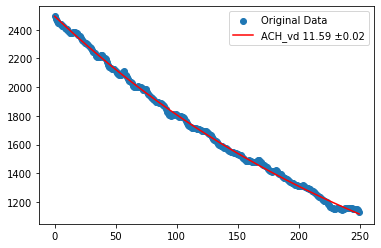

In [673]:
# find ACH_vd for this run
df_vd = df.copy()

# begin at 60s past pm2.5 max
pm25_max_idx = df_vd.idxmax()[col_fit]
start_time = df_vd.time[pm25_max_idx] + 60
if user_selected_start_time is not None:
    start_time = user_selected_start_time
start_time_idx = df_vd[df_vd.time >= start_time].index[0]
df_vd = df_vd.tail(-start_time_idx).copy()
df_vd.index -= df_vd.index[0]
time_offset = df_vd.time[0]
df_vd['time'] -= time_offset

# do this for salt CADR
# cut off all records before pm2.5 dropped to 2500
drop_start_idx = df_vd[df_vd[col_fit] <= 2500].index[0]
if drop_start_idx != 0:
    df_vd = df_vd.tail(-drop_start_idx).copy()
    df_vd.index -= df_vd.index[0]
    time_offset += df_vd.time[0]
    df_vd['time'] -= df_vd.time[0]

# end before the air purifier turns on
# for now just user-select based on time
time_stop = user_selected_stop_time - time_offset
# cut off all records after time reached user selected time
drop_start_idx = df_vd[df_vd.time >= time_stop].index[0]
if drop_start_idx != 0:
    df_vd = df_vd.head(drop_start_idx).copy()
    df_vd.index -= df_vd.index[0]
    df_vd['time'] -= df_vd.time[0]

C_pt0, popt, stderr = test_fit(df_vd)
naturaldecay_stddev = stderr * np.sqrt(len(df_vd))
ACH_vd = popt[0]
print('C_pt0: {}'.format(C_pt0))
print('ACH_vd: {}'.format(ACH_vd))
print('stderr: {}'.format(stderr))

f = DecayFuncs(0, C_pt0)

plt.scatter(df_vd.time, df_vd[col_fit], label="Original Data")
plt.plot(df_vd.time, f.func(df_vd.time, ACH_vd), 'r-', label="ACH_vd {:0.2f} ±{:0.2f}".format(ACH_vd, stderr))
plt.legend()


In [674]:

# begin window search at pm2.5 max
pm25_max_idx = df.idxmax()[col_fit]
if pm25_max_idx != 0:
    df = df.tail(-pm25_max_idx).copy()
    df.index -= df.index[0]
    df['time'] -= df.time[0]

# analyze CADR in window of [1000, 100] because error of sps 30 is multiplicative in this range, +/- 10%
# in [100, 0] error becomes +/- 10 which means error will become exaggerated at these levels
# see: https://sensirion.com/media/documents/8600FF88/616542B5/Sensirion_PM_Sensors_Datasheet_SPS30.pdf

# cut off all records before pm2.5 dropped to 1000
drop_start_idx = df[df[col_fit] <= 1000].index[0]
if drop_start_idx != 0:
    df = df.tail(-drop_start_idx).copy()
    df.index -= df.index[0]
    df['time'] -= df.time[0]

lt25_iloc = df[df[col_fit] < 100].index[0]
df = df.head(lt25_iloc).copy()

print('num data points to fit: {}'.format(len(df)))

C_pt0, popt, stderr = test_fit(df)
totaldecay_stddev = stderr * np.sqrt(len(df))
ACH = popt[0]
print('C_pt0: {}'.format(C_pt0))
print('ACH: {}'.format(ACH))
print('stderr: {}'.format(stderr))

f = DecayFuncs(0, C_pt0)


num data points to fit: 36
C_pt0: 987
ACH: 235.373269044314
stderr: 2.204026203900606


In [675]:
df.set_index('time').plot(kind='line')

For this next part don't forget to change V_r (Volume of room/chamber) to match your value.

stderr (ACH): 2.204026203900606


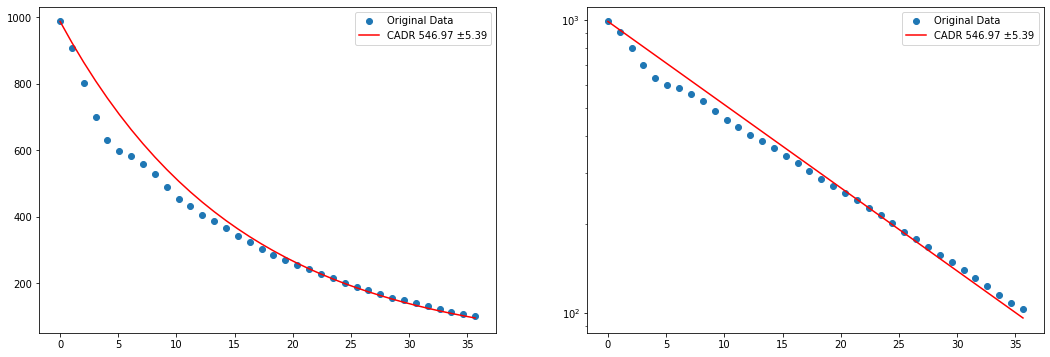

In [676]:
ACH_f = ACH - ACH_vd
# volume of room
V_r = (59. / 12) * (59. / 12) * (72.8 / 12) # this is in cubic feet
CADR = V_r * ACH_f / 60 # units of ACH are 1/h, divide by 60 to convert to 1/minutes so CADR is in cubic feet per minute
CADR_err = V_r * stderr / 60

print('stderr (ACH): {}'.format(stderr))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18,6))

plt.subplot(121)
plt.scatter(df.time, df[col_fit], label="Original Data")
plt.plot(df.time, f.func(df.time, ACH), 'r-', label="CADR {:0.2f} ±{:0.2f}".format(CADR, CADR_err))
plt.legend()

plt.subplot(122)
plt.scatter(df.time, df[col_fit], label="Original Data")
plt.plot(df.time, f.func(df.time, ACH), 'r-', label="CADR {:0.2f} ±{:0.2f}".format(CADR, CADR_err))
plt.yscale('log')
plt.legend()
#fig.suptitle('Sensirion SPS30 Trial 3')
plt.show()

In [678]:
trials = [542.59, 577.74, 546.98]

print('mean of trials: {}'.format(np.mean(trials)))
print('std error of the mean: {}'.format(scipy.stats.sem(trials)))

print()
print('natural decay std dev:', naturaldecay_stddev / 60)
print('total decay std dev:', totaldecay_stddev / 60)
S_CADR = V_r * np.sqrt((naturaldecay_stddev/60)**2 + (totaldecay_stddev/60)**2)
print('Standard deviation estimate of CADR by error propogation analysis: {}'.format(S_CADR))


mean of trials: 555.77
std error of the mean: 11.057858442453186

natural decay std dev: 0.004439062607371874
total decay std dev: 0.22040262039006062
Standard deviation estimate of CADR by error propogation analysis: 32.32931370981362
